# Nubank Credit Analysis - Study Case

## Table of Contents

<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#wrangle">Wrangling</a></li>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
    <li><a href="#predict">Predicting Models</a></li>

<a id='intro'></a>
## Introduction

> You have been given two datasets. One dataset includes application data for every customer that has been given a credit card. The other contains every card that has been given in this time and its performance. Use the data to identify which new applicants should be given a card in the future. Discuss any problems or limitations with the data, shortcomings of the analysis and/or additional data elements that might be useful. You should present your findings in a presentation lasting less than 60 minutes including time for questions. 

### Data structure

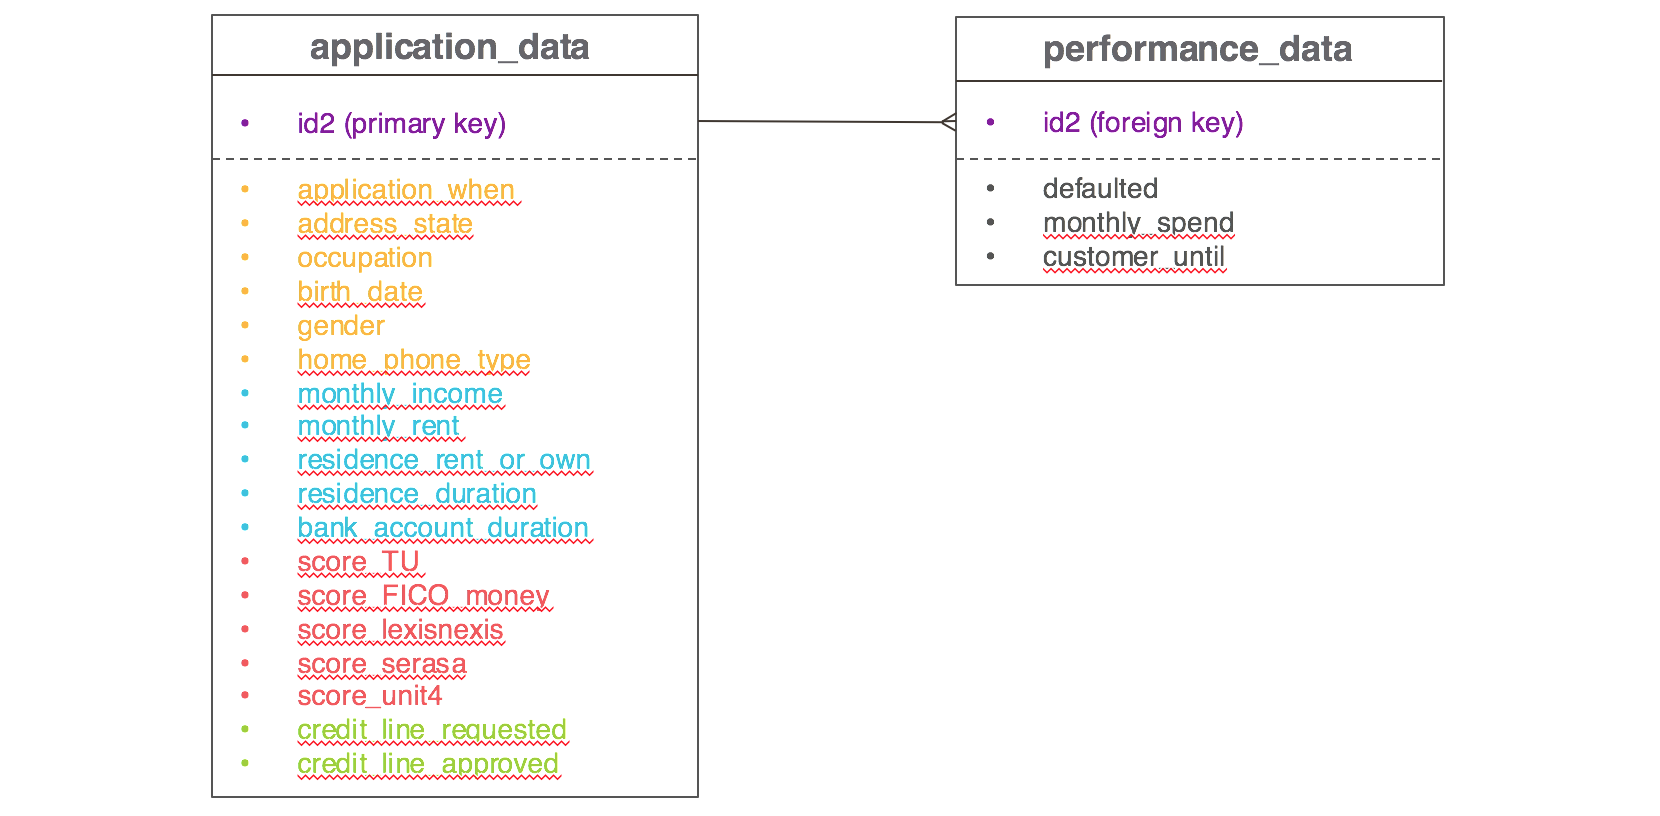

### Guiding questions

><b>Main goal is to define which customer profile should be given a card in the future.</b>

>Questions:
    <ul>
        <li>What's the percentage of default in this dataset? How much that accounted for (considering the monthly_spend)? How that percentage evolved in time?</li>
        <li>The monthly_income shows any relationship with the default probability?</li>
        <li>Does residence data show any relationship with default probability? </li>
        <li>For users without residence, is there a relationship between monthly rent and default probability? How rent and income influence the default?</li>
        <li>Como os dados de score das 5 diferentes fontes afetam a taxa de inadimplência? Existe uma correlação entre esses scores? Como eles se relacionam com outras variáveis?</li>
        <li>O montante de crédito concedido afeta a taxa de inadimplência? Como?</li>
        <li>Quais variáveis (features) possuem maior peso na predição de inadimplência de um usuário?</li>
        <li>Qual algoritmo é mais recomendado para ser usado? Por quê?</li>
        <li>Com base nos resultados do melhor algoritmo, em quanto eu melhoro a performance da minha operação de crédito? É uma taxa aceitável? Por quê?</li>


In [1]:
#Below follows all the packages used in this analysis (ML packages from Sklearn will be imported in the 
#"Predicting Models" section)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns

app_data = pd.read_csv("application_data.csv",sep=";")
app_data.head()


,Id2,application_when,address_state,occupation,birth_date,monthly_income,monthly_rent,residence_rent_or_own,residence_duration,bank_account_duration,home_phone_type,gender,score_TU,score_FICO_money,score_lexisnexis,score_serasa,score_unit4,credit_line_requested,credit_line_approved
0,1,07/08/12 15:50,SC,Casino cage worker,19/06/83,100,950,True,6 months or less,3+ years,Mobile,female,411,699,440,102,418,1500,1100
1,2,07/10/12 20:24,PE,Astronautical engineer,16/09/76,10500,2400,False,3+ years,3+ years,Mobile,male,753,850,575,89,385,25500,24900
2,3,27/11/14 21:15,ES,Conference service coordinator,03/08/76,7700,100,True,1-2 years,3+ years,Mobile,male,478,646,464,670,213,9000,8100
3,4,19/10/12 16:52,SP,Contract skidder,26/08/81,10200,3000,False,1-2 years,3+ years,Mobile,female,787,850,645,728,435,24000,23500
4,5,29/04/13 13:06,SP,Macromolecular chemist,23/09/95,3000,0,True,3+ years,6 months or less,Home,male,780,850,690,305,398,5500,4600


In [2]:
perf_data = pd.read_csv("performance_data.csv",sep=";")
perf_data.head()

,id2,defaulted (Failed to pay his bill),monthly_spend,customer_until
0,1,False,9,NaN
1,2,False,2771,NaN
2,3,False,866,NaN
3,5,False,896,NaN
4,6,True,1350,02/03/14


<a id='wrangle'></a>
## Data Wrangling

> In this section of the report, I will load in the data, check for types, nulls and duplicates, and then trim and clean the columns of the dataset for analysis. Every step follows below along with justified decisions. In the code blocks, there are notes starting with a "#" describing what the code does.

### Database General Properties

In [3]:
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 19 columns):
Id2                      9458 non-null int64
application_when         9458 non-null object
address_state            9458 non-null object
occupation               9458 non-null object
birth_date               9458 non-null object
monthly_income           9458 non-null int64
monthly_rent             9458 non-null int64
residence_rent_or_own    9458 non-null bool
residence_duration       9458 non-null object
bank_account_duration    9444 non-null object
home_phone_type          9458 non-null object
gender                   9458 non-null object
score_TU                 9458 non-null int64
score_FICO_money         9458 non-null int64
score_lexisnexis         9458 non-null int64
score_serasa             9458 non-null int64
score_unit4              9458 non-null int64
credit_line_requested    9458 non-null int64
credit_line_approved     9458 non-null int64
dtypes: bool(1), int64(10), obj

In [4]:
perf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9221 entries, 0 to 9220
Data columns (total 4 columns):
id2                                   9221 non-null int64
defaulted (Failed to pay his bill)    9221 non-null bool
monthly_spend                         9221 non-null int64
customer_until                        3052 non-null object
dtypes: bool(1), int64(2), object(1)
memory usage: 225.2+ KB


## Changes

> <ul>
    <li>Inner join the app_data into perf_data so we have all the info in one data table by using the id2 column. By doing this, customers without any performance data will be dropped, which is also required.</li>
    <li>Check for duplicates</li>
    <li>Change the "defaulted (Failed to pay his bill)" column name to just defaulted</li>
    <li>Transform both bool columns (residence_rent_or_own in app_data and defaulted in perf_data) so we can easily perform mathematical operations on them.</li>
    <li> The 'bank_account_duration' column have a few null values. These entries will also be dropped.</li>
    <li> Convert the 'application_when' from object to date format (year and month).</li>
    <li> Drop the 'customer_until' variable as it will not be used in the analysis.</li>
  </ul>

In [59]:
#left join app_data into perf_data
app_data=app_data.rename(columns = {'Id2':'id2'})
df = pd.merge(app_data,perf_data,on='id2')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9221 entries, 0 to 9220
Data columns (total 22 columns):
id2                                   9221 non-null int64
application_when                      9221 non-null object
address_state                         9221 non-null object
occupation                            9221 non-null object
birth_date                            9221 non-null object
monthly_income                        9221 non-null int64
monthly_rent                          9221 non-null int64
residence_rent_or_own                 9221 non-null bool
residence_duration                    9221 non-null object
bank_account_duration                 9207 non-null object
home_phone_type                       9221 non-null object
gender                                9221 non-null object
score_TU                              9221 non-null int64
score_FICO_money                      9221 non-null int64
score_lexisnexis                      9221 non-null int64
score_serasa    

In [60]:
#check for duplicates
df.duplicated().sum()

0

In [61]:
#change the default column name and transform bool columns into float (True = 1, False = 0)

df=df.rename(columns = {'defaulted (Failed to pay his bill)':'defaulted'})
df['residence_rent_or_own'] = df['residence_rent_or_own'].map({True: 1, False: 0})
df['defaulted'] = df['defaulted'].map({True: 1, False: 0})
df.head()
        

,id2,application_when,address_state,occupation,birth_date,monthly_income,monthly_rent,residence_rent_or_own,residence_duration,bank_account_duration,...,score_TU,score_FICO_money,score_lexisnexis,score_serasa,score_unit4,credit_line_requested,credit_line_approved,defaulted,monthly_spend,customer_until
0,1,07/08/12 15:50,SC,Casino cage worker,19/06/83,100,950,1,6 months or less,3+ years,...,411,699,440,102,418,1500,1100,0,9,NaN
1,2,07/10/12 20:24,PE,Astronautical engineer,16/09/76,10500,2400,0,3+ years,3+ years,...,753,850,575,89,385,25500,24900,0,2771,NaN
2,3,27/11/14 21:15,ES,Conference service coordinator,03/08/76,7700,100,1,1-2 years,3+ years,...,478,646,464,670,213,9000,8100,0,866,NaN
3,5,29/04/13 13:06,SP,Macromolecular chemist,23/09/95,3000,0,1,3+ years,6 months or less,...,780,850,690,305,398,5500,4600,0,896,NaN
4,6,02/12/13 17:59,SP,Clinical psychologist,23/12/62,8000,1700,0,7-12 months,3+ years,...,200,159,200,757,259,26500,26200,1,1350,02/03/14


In [62]:
#drop bank_account_duration NA entries
df = df[pd.notnull(df.bank_account_duration)]

In [63]:
#convert the 'application_when' from object to date format.
df['application_when'] = pd.to_datetime(df['application_when'],format='%d/%m/%y %H:%M')

df['application_date'] = pd.DatetimeIndex(df.application_when).normalize()
df['application_date'] = df.application_date.map(lambda x: x.strftime('%Y-%m'))

In [64]:
#remove the customer_until variable from the analysis
df = df.drop('customer_until', axis=1)
df_cleaned = df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9207 entries, 0 to 9220
Data columns (total 22 columns):
id2                      9207 non-null int64
application_when         9207 non-null datetime64[ns]
address_state            9207 non-null object
occupation               9207 non-null object
birth_date               9207 non-null object
monthly_income           9207 non-null int64
monthly_rent             9207 non-null int64
residence_rent_or_own    9207 non-null int64
residence_duration       9207 non-null object
bank_account_duration    9207 non-null object
home_phone_type          9207 non-null object
gender                   9207 non-null object
score_TU                 9207 non-null int64
score_FICO_money         9207 non-null int64
score_lexisnexis         9207 non-null int64
score_serasa             9207 non-null int64
score_unit4              9207 non-null int64
credit_line_requested    9207 non-null int64
credit_line_approved     9207 non-null int64
defaulted             

<a id='eda'></a>
## Exploratory Data Analysis

> Now that the dataset is trimmed and cleaned, let's move on to exploration. In this section, I will ask potential questions about the variables of the dataset, compute statistics and create visualizations with the goal of addressing our main research question: is it possible to predict patient no-show? If it is, which variables are the main drivers of patients deciding to show or not? 

### What's the percentage of default in this dataset? How much that accounted for (considering the monthly_spend)? How the percentage evolved over time?

In [11]:
df.describe()

,id2,monthly_income,monthly_rent,residence_rent_or_own,score_TU,score_FICO_money,score_lexisnexis,score_serasa,score_unit4,credit_line_requested,credit_line_approved,defaulted,monthly_spend
count,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000,9207.000000
mean,4730.249267,4244.802867,1234.636689,0.641686,513.851960,518.164549,467.708483,248.196590,395.167916,8734.821332,7904.268491,0.222331,1012.797437
std,2730.507076,3494.195068,1069.856593,0.479531,219.036183,244.793977,158.237881,244.492728,156.162779,7937.779548,7928.752928,0.415835,1144.211995
min,1.000000,0.000000,0.000000,0.000000,200.000000,100.000000,200.000000,0.000000,-4.000000,1500.000000,1000.000000,0.000000,0.000000
25%,2364.500000,1700.000000,400.000000,0.000000,264.000000,311.000000,315.000000,27.000000,295.000000,2000.000000,1200.000000,0.000000,287.000000
50%,4731.000000,3400.000000,1000.000000,1.000000,576.000000,548.000000,500.000000,157.000000,390.000000,5000.000000,4200.000000,0.000000,740.000000
75%,7092.500000,5700.000000,1800.000000,1.000000,717.000000,729.000000,607.000000,451.000000,486.000000,15000.000000,14100.000000,0.000000,1361.000000
max,9458.000000,22200.000000,7000.000000,1.000000,800.000000,850.000000,690.000000,800.000000,800.000000,40500.000000,38300.000000,1.000000,23074.000000


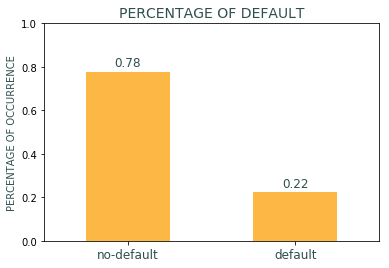

In [12]:
#proportion of defaulted and no-defaulted
proportions = df['defaulted'].value_counts()/df['defaulted'].count()

y_labels = ['no-default','default']
ax = proportions.plot(kind='bar', figsize=(6,4),tick_label = y_labels, color='#fcb744')
ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,1)
ax.set_title('PERCENTAGE OF DEFAULT',color='#2f4f4f',fontsize=14);
plt.xticks(np.arange(2), y_labels,rotation=0,fontsize=12,color='#2f4f4f')

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(proportions)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

In [13]:
#number of defaulted users and loss
defaulted = df.query('defaulted == 1')
n_defaults = defaulted.monthly_spend.count()
m_defaults = defaulted.monthly_spend.sum()
print("{} defaulted users, resulting in a loss of R${:,}".format(n_defaults,m_defaults))

2047 defaulted users, resulting in a loss of R$2,145,842


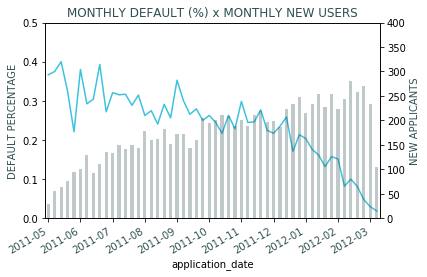

In [14]:
#evolution of defaulted percentage
monthly_defaulted = df.groupby(df['application_date']).defaulted.mean()
monthly_users = df.groupby(df['application_date']).id2.count()

fig, ax = plt.subplots()
ax.plot(monthly_defaulted, color='#3dc2de')
plt.title('MONTHLY DEFAULT (%) x MONTHLY NEW USERS',color='#2f4f4f',fontsize=12)
plt.xticks(fontsize=10,color='#2f4f4f')
plt.ylabel('DEFAULT PERCENTAGE',color='#2f4f4f',fontsize=10)
ax.set_ylim(0,0.5)
ax2 = monthly_users.plot(kind='bar',secondary_y=True,color='#2f4f4f',alpha=0.3)
ax2.set_ylabel('NEW APPLICANTS',fontsize=10,color='#2f4f4f')
ax2.set_ylim(0,400)

fig.autofmt_xdate()
myLocator = mticker.MultipleLocator(5)
ax.xaxis.set_major_locator(myLocator)

### Does monthly_income show any relationship with the default probability? 

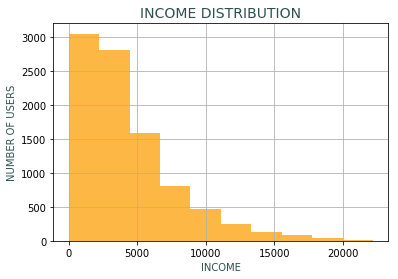

In [15]:
#Distribution of monthly_income
df['monthly_income'].hist(color='#fcb744');
plt.title('INCOME DISTRIBUTION',color='#2f4f4f',fontsize=14)
plt.ylabel('NUMBER OF USERS',color='#2f4f4f',fontsize=10)
plt.xlabel('INCOME',color='#2f4f4f',fontsize=10);

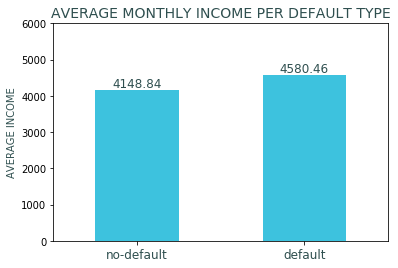

In [16]:
#Analysis of average monthly income per defaulted and no-defaulted users
avg_income_per_default = df.groupby(['defaulted']).mean()['monthly_income']

y_labels = ['no-default','default']
ax = avg_income_per_default.plot(kind='bar', figsize=(6,4),tick_label = y_labels, color='#3dc2de')
ax.set_ylabel('AVERAGE INCOME',fontsize=10,color='#2f4f4f')
ax.set_xlabel('',fontsize=11,color='#2f4f4f')
ax.set_ylim(0,6000)
ax.set_title('AVERAGE MONTHLY INCOME PER DEFAULT TYPE',color='#2f4f4f',fontsize=14);
plt.xticks(np.arange(2), y_labels,rotation=0,fontsize=12,color='#2f4f4f')

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(avg_income_per_default)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

In [17]:
#create divisions in monthly_income using the min, 25% quantile, 50% quantile, 75% quantile and max
income_mean = round(df.monthly_income.mean(),0)
income_q1 = round(df.monthly_income.quantile(q=0.25),0)
income_q3 = round(df.monthly_income.quantile(q=0.75),0)
income_min = df.monthly_income.min()
income_max = df.monthly_income.max()

income_div = [income_min,income_q1,income_mean,income_q3,income_max]
income_labels = ['< {}'.format(income_q1),'{} - {}'.format(income_q1,income_mean),'{} - {}'.format(income_mean,income_q3),'> {}'.format(income_q3)]

df['income_seg'] = pd.cut(df['monthly_income'], income_div, labels=income_labels)

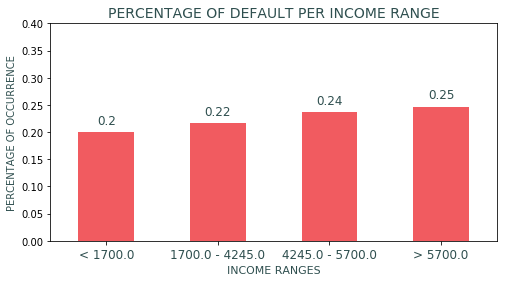

In [18]:
#Evaluate, for each monthly_income range, the average default
income_default = df.groupby(['income_seg']).mean()['defaulted']
y_labels = income_labels

ax = income_default.plot(kind='bar', figsize=(8,4), color='#f15b60')
ax.set_xlabel('INCOME RANGES',fontsize=11,color='#2f4f4f')
ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,0.4)
ax.set_title('PERCENTAGE OF DEFAULT PER INCOME RANGE',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=12,color='#2f4f4f');

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(income_default)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

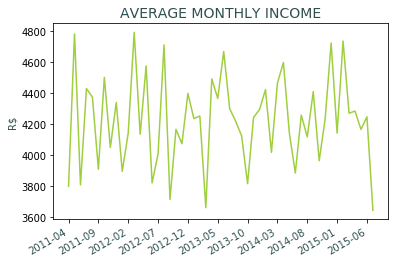

In [19]:
#evolution of monthly income 
monthly_income_evol = df.groupby(df['application_date']).monthly_income.mean()

fig, ax = plt.subplots()
ax.plot(monthly_income_evol, color='#9fce3e')
plt.title('AVERAGE MONTHLY INCOME',color='#2f4f4f',fontsize=14)
plt.xticks(fontsize=10,color='#2f4f4f')
plt.ylabel('R$',color='#2f4f4f',fontsize=10)
fig.autofmt_xdate()
myLocator = mticker.MultipleLocator(5)
ax.xaxis.set_major_locator(myLocator)

### Does residence data show any relationship with default probability?

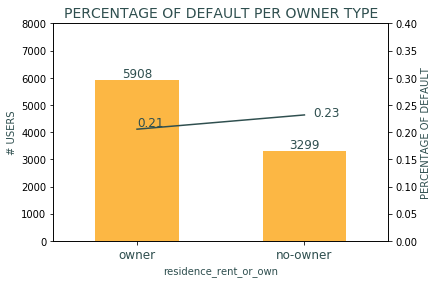

In [20]:
#Analysis of # of owners and no-owners and their default probability
n_per_owner_type = df['residence_rent_or_own'].value_counts()
avg_default_per_owner = df.groupby(['residence_rent_or_own']).mean()['defaulted']

y_labels = ['owner','no-owner']
ax = n_per_owner_type.plot(kind='bar', figsize=(6,4), color='#fcb744')
ax.set_ylabel('# USERS',fontsize=10,color='#2f4f4f')
ax.set_xlabel('',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,8000)
ax.set_title('PERCENTAGE OF DEFAULT PER OWNER TYPE',color='#2f4f4f',fontsize=14);
plt.xticks(np.arange(2), y_labels,rotation=0,fontsize=12,color='#2f4f4f')

ax2 = avg_default_per_owner.plot(secondary_y=True, color='#2f4f4f')
ax2.set_ylim(0,0.4)
ax2.set_xlabel('',fontsize=11,color='#2f4f4f')
ax2.set_ylabel('PERCENTAGE OF DEFAULT',fontsize=10,color='#2f4f4f')

rects1 = ax.patches
labels1 = [str(round(v,2)) for i,v in enumerate(n_per_owner_type)]

for rect, label in zip(rects1, labels1):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

for i,j in avg_default_per_owner.round(2).items():
    ax2.annotate(s= str(j), xy=(i, j), xytext=(i*1.05, j)
               ,fontsize=12,color='#2f4f4f')

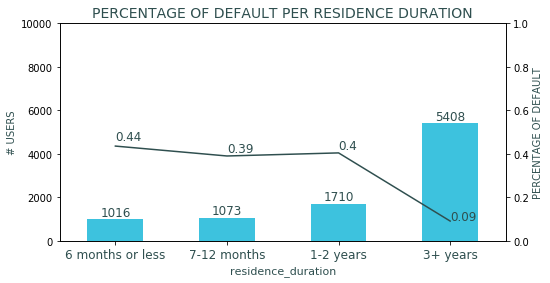

In [21]:
#analyse average default per residence_duration
y_labels = ['6 months or less','7-12 months','1-2 years','3+ years']

n_per_residency_time = df['residence_duration'].value_counts().reindex(y_labels)
income_default = df.groupby(['residence_duration']).mean()['defaulted'].reindex(y_labels)

ax = n_per_residency_time.plot(kind='bar', figsize=(8,4), color='#3dc2de')
ax.set_xlabel('',fontsize=11,color='#2f4f4f')
ax.set_ylabel('# USERS',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,10000)
ax.set_title('PERCENTAGE OF DEFAULT PER RESIDENCE DURATION',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=12,color='#2f4f4f');

ax2 = income_default.plot(secondary_y=True,color='#2f4f4f')
ax2.set_ylim(0,1)
ax2.set_xlabel('',fontsize=11,color='#2f4f4f')
ax2.set_ylabel('PERCENTAGE OF DEFAULT',fontsize=10,color='#2f4f4f')

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(n_per_residency_time)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

for i,j in income_default.reset_index()['defaulted'].round(2).items():
    ax2.annotate(s= str(j), xy=(i, j), xytext=(i, j*1.05)
               ,fontsize=12,color='#2f4f4f')    

### What's the default percentage for residence owners for each residence duration?

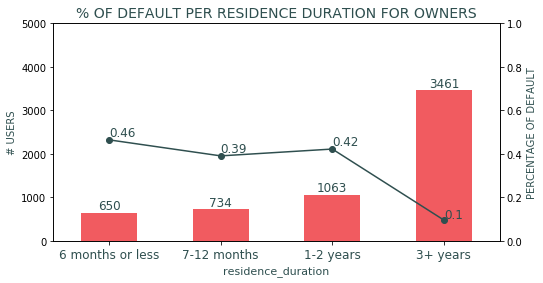

In [22]:
#analysis of average default per residence_duration for residence owners
y_labels = ['6 months or less','7-12 months','1-2 years','3+ years']

n_per_residency_time = df.query('residence_rent_or_own == 1')['residence_duration'].value_counts().reindex(y_labels)
income_default = df.query('residence_rent_or_own == 1').groupby(['residence_duration']).mean()['defaulted'].reindex(y_labels)

ax = n_per_residency_time.plot(kind='bar', figsize=(8,4), color='#f15b60')
ax.set_xlabel('',fontsize=11,color='#2f4f4f')
ax.set_ylabel('# USERS',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,5000)
ax.set_title('% OF DEFAULT PER RESIDENCE DURATION FOR OWNERS',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=12,color='#2f4f4f');

ax2 = income_default.plot(secondary_y=True,color='#2f4f4f',marker = 'o')
ax2.set_ylim(0,1)
ax2.set_xlabel('',fontsize=11,color='#2f4f4f')
ax2.set_ylabel('PERCENTAGE OF DEFAULT',fontsize=10,color='#2f4f4f',)

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(n_per_residency_time)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

for i,j in income_default.reset_index()['defaulted'].round(2).items():
    ax2.annotate(s= str(j), xy=(i, j), xytext=(i, j*1.05)
               ,fontsize=12,color='#2f4f4f')    

### What about for no-owners? And how monthly rent affects the default? Is there a relationship between rent and income?

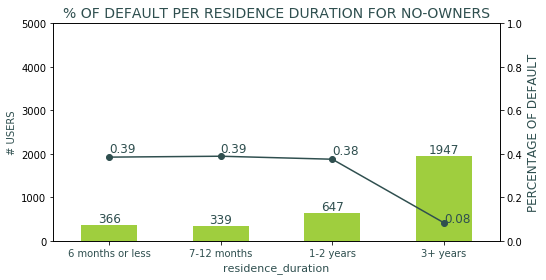

In [23]:
#analysis of average default per residence_duration for residence no-owners
y_labels = ['6 months or less','7-12 months','1-2 years','3+ years']

n_per_residency_time = df.query('residence_rent_or_own == 0')['residence_duration'].value_counts().reindex(y_labels)
residency_default = df.query('residence_rent_or_own == 0').groupby(['residence_duration']).mean()['defaulted'].reindex(y_labels)

ax = n_per_residency_time.plot(kind='bar', figsize=(8,4), color='#9fce3e')
ax.set_xlabel('',fontsize=11,color='#2f4f4f')
ax.set_ylabel('# USERS',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,5000)
ax.set_title('% OF DEFAULT PER RESIDENCE DURATION FOR NO-OWNERS',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=10,color='#2f4f4f');

ax2 = residency_default.plot(secondary_y=True,color='#2f4f4f',marker = 'o')
ax2.set_ylim(0,1)
ax2.set_xlabel('',fontsize=11,color='#2f4f4f')
ax2.set_ylabel('PERCENTAGE OF DEFAULT',fontsize=12,color='#2f4f4f')

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(n_per_residency_time)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

for i,j in residency_default.reset_index()['defaulted'].round(2).items():
    ax2.annotate(s= str(j), xy=(i, j), xytext=(i, j*1.05)
               ,fontsize=12,color='#2f4f4f')    

### How bank_account_duration influences the default ratio?

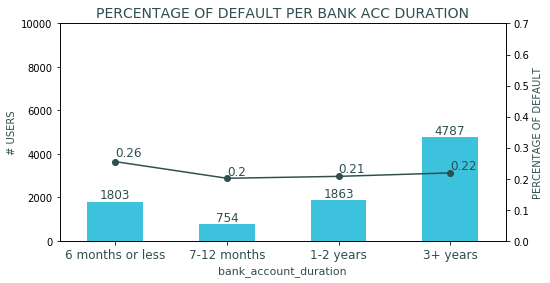

In [24]:
#analysis of average default per bank_account_duration
y_labels = ['6 months or less','7-12 months','1-2 years','3+ years']

n_per_bank_time = df['bank_account_duration'].value_counts().reindex(y_labels)
bank_default = df.groupby(['bank_account_duration']).mean()['defaulted'].reindex(y_labels)

ax = n_per_bank_time.plot(kind='bar', figsize=(8,4), color='#3dc2de')
ax.set_xlabel('',fontsize=11,color='#2f4f4f')
ax.set_ylabel('# USERS',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,10000)
ax.set_title('PERCENTAGE OF DEFAULT PER BANK ACC DURATION',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=12,color='#2f4f4f');

ax2 = bank_default.plot(secondary_y=True,color='#2f4f4f',marker = 'o')
ax2.set_ylim(0,0.7)
ax2.set_xlabel('',fontsize=11,color='#2f4f4f')
ax2.set_ylabel('PERCENTAGE OF DEFAULT',fontsize=10,color='#2f4f4f')

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(n_per_bank_time)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

for i,j in bank_default.reset_index()['defaulted'].round(2).items():
    ax2.annotate(s= str(j), xy=(i, j), xytext=(i, j*1.05)
               ,fontsize=12,color='#2f4f4f')    

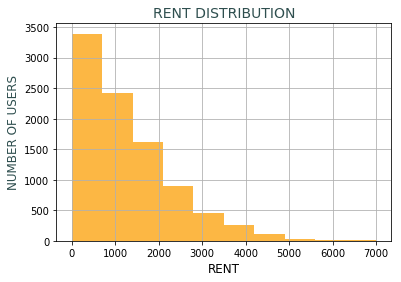

In [25]:
#Rent distribution
df['monthly_rent'].hist(color='#fcb744');
plt.title('RENT DISTRIBUTION',color='#2f4f4f',fontsize=14)
plt.ylabel('NUMBER OF USERS',color='#2f4f4f',fontsize=12)
plt.xlabel('RENT',fontsize=12);

In [26]:
#create divisions in monthly_rent using the min, 25% quantile, 50% quantile, 75% quantile and max
rent_mean = round(df.monthly_rent.mean(),0)
rent_q1 = round(df.monthly_rent.quantile(q=0.25),0)
rent_q3 = round(df.monthly_rent.quantile(q=0.75),0)
rent_min = df.monthly_rent.min()
rent_max = df.monthly_rent.max()

rent_div = [rent_min,rent_q1,rent_mean,rent_q3,rent_max]
rent_labels = ['< {}'.format(rent_q1),'{} - {}'.format(rent_q1,rent_mean),'{} - {}'.format(rent_mean,rent_q3),'> {}'.format(rent_q3)]

df['rent_seg'] = pd.cut(df['monthly_rent'], rent_div, labels=rent_labels)

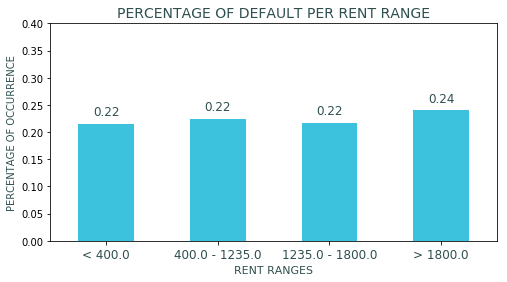

In [27]:
#analysis of defaulted percentage per monthly_rent range
rent_default = df.groupby(['rent_seg']).mean()['defaulted']
y_labels = rent_labels

ax = rent_default.plot(kind='bar', figsize=(8,4), color='#3dc2de')
ax.set_xlabel('RENT RANGES',fontsize=11,color='#2f4f4f')
ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,0.4)
ax.set_title('PERCENTAGE OF DEFAULT PER RENT RANGE',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=12,color='#2f4f4f');

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(rent_default)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

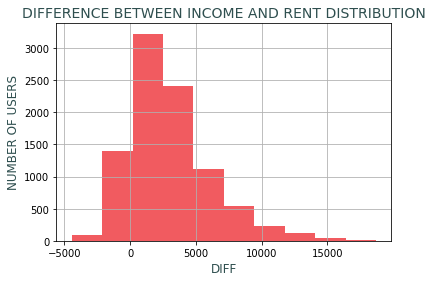

In [28]:
#created a new feature, the difference between monthly income
df['rent_income_diff'] = df['monthly_income'] - df['monthly_rent']
df['rent_income_diff'].hist(color='#f15b60');
plt.title('DIFFERENCE BETWEEN INCOME AND RENT DISTRIBUTION',color='#2f4f4f',fontsize=14)
plt.ylabel('NUMBER OF USERS',color='#2f4f4f',fontsize=12)
plt.xlabel('DIFF',color='#2f4f4f',fontsize=12);

In [29]:
#create divisions in the new feature (income-rent) using the min, 25% quantile, 50% quantile, 75% quantile and max
diff_mean = round(df.rent_income_diff.mean(),0)
diff_q1 = round(df.rent_income_diff.quantile(q=0.25),0)
diff_q3 = round(df.rent_income_diff.quantile(q=0.75),0)
diff_min = df.rent_income_diff.min()
diff_max = df.rent_income_diff.max()

diff_div = [diff_min,diff_q1,diff_mean,diff_q3,diff_max]
diff_labels = ['< {}'.format(diff_q1),'{} - {}'.format(diff_q1,diff_mean),'{} - {}'.format(diff_mean,diff_q3),'> {}'.format(diff_q3)]

df['rent_income_diff_seg'] = pd.cut(df['rent_income_diff'], diff_div, labels=diff_labels)
df.head()

,id2,application_when,address_state,occupation,birth_date,monthly_income,monthly_rent,residence_rent_or_own,residence_duration,bank_account_duration,...,score_unit4,credit_line_requested,credit_line_approved,defaulted,monthly_spend,application_date,income_seg,rent_seg,rent_income_diff,rent_income_diff_seg
0,1,2012-08-07 15:50:00,SC,Casino cage worker,19/06/83,100,950,1,6 months or less,3+ years,...,418,1500,1100,0,9,2012-08,< 1700.0,400.0 - 1235.0,-850,< 750.0
1,2,2012-10-07 20:24:00,PE,Astronautical engineer,16/09/76,10500,2400,0,3+ years,3+ years,...,385,25500,24900,0,2771,2012-10,> 5700.0,> 1800.0,8100,> 4500.0
2,3,2014-11-27 21:15:00,ES,Conference service coordinator,03/08/76,7700,100,1,1-2 years,3+ years,...,213,9000,8100,0,866,2014-11,> 5700.0,< 400.0,7600,> 4500.0
3,5,2013-04-29 13:06:00,SP,Macromolecular chemist,23/09/95,3000,0,1,3+ years,6 months or less,...,398,5500,4600,0,896,2013-04,1700.0 - 4245.0,NaN,3000,750.0 - 3010.0
4,6,2013-12-02 17:59:00,SP,Clinical psychologist,23/12/62,8000,1700,0,7-12 months,3+ years,...,259,26500,26200,1,1350,2013-12,> 5700.0,1235.0 - 1800.0,6300,> 4500.0


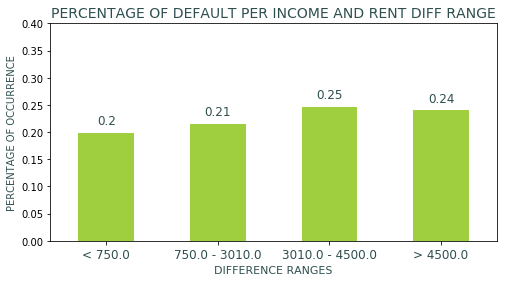

In [30]:
#analysis of defaulted percentage per diff range
diff_default = df.groupby(['rent_income_diff_seg']).mean()['defaulted']
y_labels = diff_labels

ax = diff_default.plot(kind='bar', figsize=(8,4), color='#9fce3e')
ax.set_xlabel('DIFFERENCE RANGES',fontsize=11,color='#2f4f4f')
ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,0.4)
ax.set_title('PERCENTAGE OF DEFAULT PER INCOME AND RENT DIFF RANGE',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), y_labels,rotation=0,fontsize=12,color='#2f4f4f');

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(diff_default)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

### Como os dados de score das 5 diferentes fontes afetam a taxa de inadimplência? Existe uma correlação entre esses scores? Como eles se relacionam com outras variáveis?

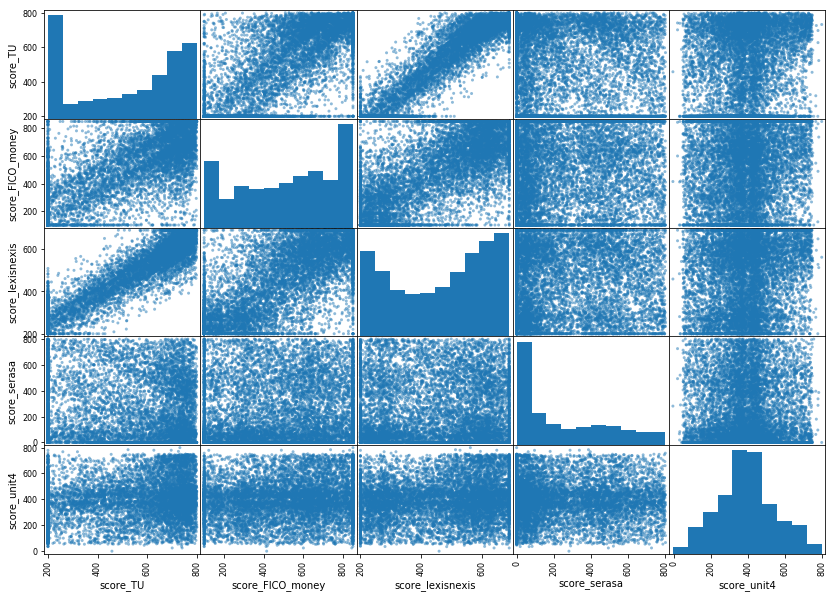

In [31]:
#scatterplot matrix to evaluate the relationship between the different scores
df_scores = df[['score_TU', 'score_FICO_money', 'score_lexisnexis', 'score_serasa', 'score_unit4']]
pd.plotting.scatter_matrix (df_scores,figsize=(14,10));

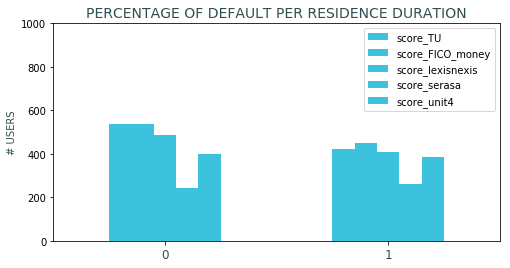

In [32]:
df_scores_default = df[['score_TU', 'score_FICO_money', 'score_lexisnexis', 'score_serasa', 'score_unit4','defaulted']]
ax = df_scores_default.groupby(df_scores_default.defaulted).mean().plot(kind='bar', figsize=(8,4), color='#3dc2de')
ax.set_xlabel('',fontsize=11,color='#2f4f4f')
ax.set_ylabel('# USERS',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,1000)
ax.set_title('PERCENTAGE OF DEFAULT PER RESIDENCE DURATION',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(2), rotation=0,fontsize=12,color='#2f4f4f');

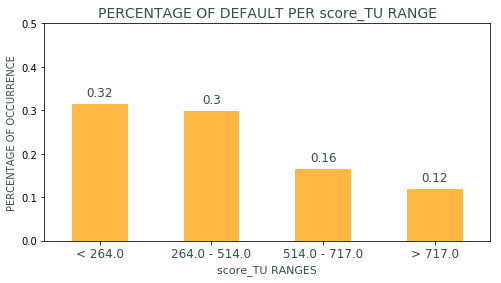

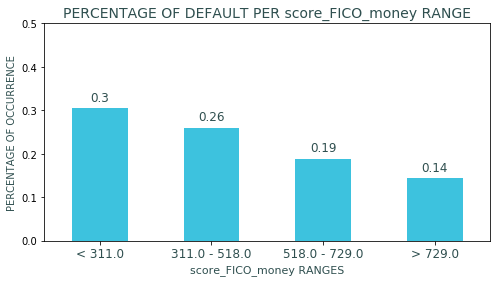

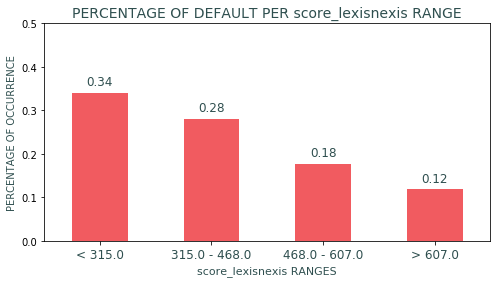

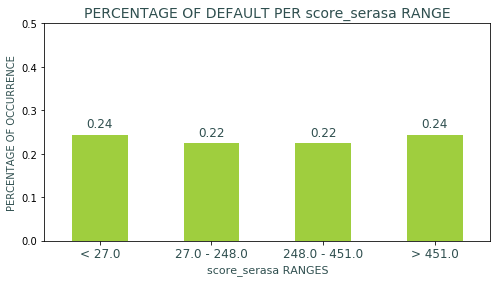

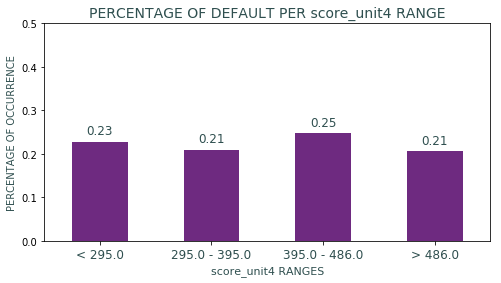

In [33]:
#divide each score in min, q1, mean, q3 and max to evaluate the default percentage of each range
"""
Function to divide data intro min, quartile 1, mean, quartile 3 and max. 
Imput:
    Data series
Output:
    Labeled data series
"""
def divide_quartiles(data):
    #create divisions in monthly_income using the min, 25% quantile, 50% quantile, 75% quantile and max
    mean = round(data.mean(),0)
    q1 = round(data.quantile(q=0.25),0)
    q3 = round(data.quantile(q=0.75),0)
    min = data.min()
    max = data.max()

    divs = [min,q1,mean,q3,max]
    labels = ['< {}'.format(q1),'{} - {}'.format(q1,mean),'{} - {}'.format(mean,q3),'> {}'.format(q3)]
    return pd.cut(data, divs, labels=labels)

colors = ['#fcb744','#3dc2de','#f15b60','#9fce3e','#6e2a80']

for i,v in zip(df_scores.iloc[:,:].columns,colors):
    df['{}_segs'.format(i)] = divide_quartiles(df[i])
    i_approved = df.groupby(['{}_segs'.format(i)]).mean()['defaulted']
    fig, axes = plt.subplots()
    ax = i_approved.plot(kind='bar', figsize=(8,4), color= v)
    ax.set_xlabel('{} RANGES'.format(i),fontsize=11,color='#2f4f4f')
    ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
    ax.set_ylim(0,0.5)
    ax.set_title('PERCENTAGE OF DEFAULT PER {} RANGE'.format(i),color='#2f4f4f',fontsize=14)
    plt.xticks(np.arange(4), rotation=0,fontsize=12,color='#2f4f4f');

    rects = ax.patches
    labels = [str(round(v,2)) for i,v in enumerate(i_approved)]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')
    

### O montante de crédito concedido afeta a taxa de inadimplência? Como?

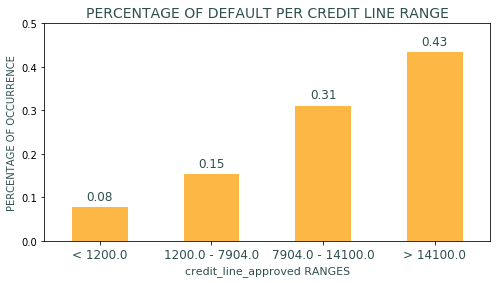

In [34]:
df['credit_line_approved_segs'] = divide_quartiles(df.credit_line_approved)
cl_approved_default = df.groupby(['credit_line_approved_segs']).mean()['defaulted']

ax = cl_approved_default.plot(kind='bar', figsize=(8,4), color='#fcb744')
ax.set_xlabel('credit_line_approved RANGES',fontsize=11,color='#2f4f4f')
ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,0.5)
ax.set_title('PERCENTAGE OF DEFAULT PER CREDIT LINE RANGE',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), rotation=0,fontsize=12,color='#2f4f4f');

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(cl_approved_default)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

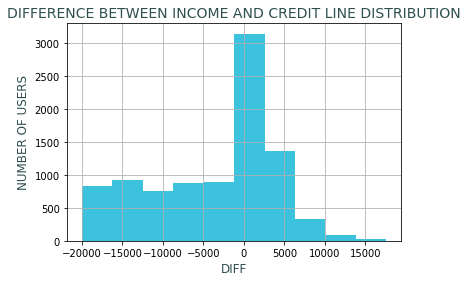

In [35]:
#created a new feature, the difference between monthly income and credit line approved
df['cl_income_diff'] = df['monthly_income'] - df['credit_line_approved']
df['cl_income_diff'].hist(color='#3dc2de');
plt.title('DIFFERENCE BETWEEN INCOME AND CREDIT LINE DISTRIBUTION',color='#2f4f4f',fontsize=14)
plt.ylabel('NUMBER OF USERS',color='#2f4f4f',fontsize=12)
plt.xlabel('DIFF',color='#2f4f4f',fontsize=12);

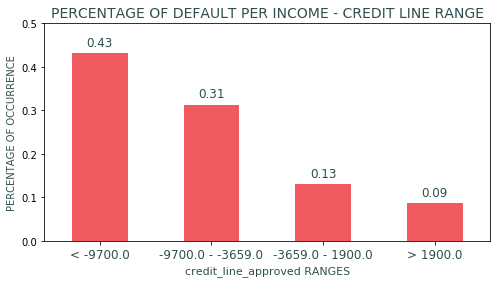

In [36]:
df['income_cl_diff_segs'] = divide_quartiles(df.cl_income_diff)
income_cl_diff_default = df.groupby(['income_cl_diff_segs']).mean()['defaulted']

ax = income_cl_diff_default.plot(kind='bar', figsize=(8,4), color='#f15b60')
ax.set_xlabel('credit_line_approved RANGES',fontsize=11,color='#2f4f4f')
ax.set_ylabel('PERCENTAGE OF OCCURRENCE',fontsize=10,color='#2f4f4f')
ax.set_ylim(0,0.5)
ax.set_title('PERCENTAGE OF DEFAULT PER INCOME - CREDIT LINE RANGE',color='#2f4f4f',fontsize=14)
plt.xticks(np.arange(4), rotation=0,fontsize=12,color='#2f4f4f');

rects = ax.patches
labels = [str(round(v,2)) for i,v in enumerate(income_cl_diff_default)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=12,color='#2f4f4f')

In [37]:
best_profile = df.query('residence_duration == "3+ years" & score_TU > 717 & cl_income_diff > 0')
count = best_profile.id2.count()
ratio = round(best_profile.defaulted.mean()*100,2)
cost = best_profile.query('defaulted==1').monthly_spend.sum()

print ('{} users, with an average default of {}% and a forecasted default cost of R${:,}'.format(count,ratio,cost))

551 users, with an average default of 0.54% and a forecasted default cost of R$7,664


<a id='predict'></a>
## Predicting Models

> Finally, we use algorithms to try to predict whether a user will default or not based on the dataset provided. 

### KNN (K-nearest neightbours)

>Pros:
><ul>
    <li>Simple to implement
    <li>Training is trivial
    <li>It can work with any number of classes
    <li>Easy to add more data
    <li>It has very few parameters (K and distance metric).

>Cons:
><ul>
    <li>It has high computation cost.
    <li>It is not suitable for high dimensional data and categorical features.

In [46]:
#Assign input & output variables
df_4_models = df_cleaned.drop(['id2','application_when','address_state','occupation','birth_date','application_date','defaulted'], axis=1)
df_4_models['cl_income_diff'] = df['monthly_income'] - df['credit_line_approved']
continuous_vars = df_4_models[['monthly_income','monthly_rent','score_TU','score_FICO_money','score_lexisnexis','score_serasa','score_unit4','cl_income_diff']]

X = continuous_vars
y = df_cleaned['defaulted']

#Split the data set into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
        
#Import KNN
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train,y_train)

#Test the model
pred = knn.predict(X_test)

#Measure the accuracy of the KNN model
from sklearn.metrics import classification_report

print (classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.81      0.90      0.85      2152
          1       0.43      0.27      0.33       611

avg / total       0.73      0.76      0.74      2763



In [47]:
#importing MinMaxScaler and initializing it
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()

# Scaling down both train and test data set
X_train_minmax=min_max.fit_transform(X_train)
X_test_minmax=min_max.fit_transform(X_test)
knn.fit(X_train_minmax,y_train)

pred = knn.predict(X_test_minmax)

#Measure the accuracy of the scaled KNN model
from sklearn.metrics import classification_report

print (classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86      2152
          1       0.49      0.32      0.38       611

avg / total       0.75      0.78      0.76      2763



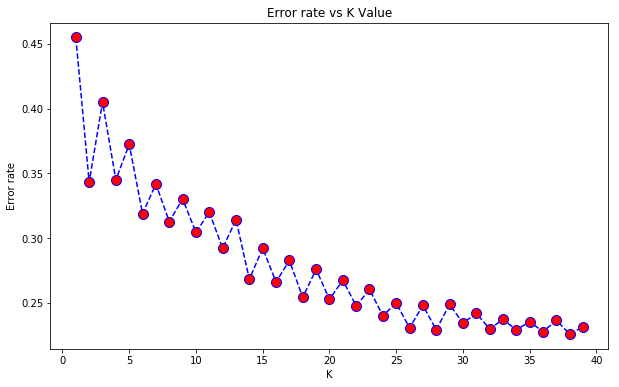

In [44]:
error_rate = []

for i in range(1, 40):
	knn = KNeighborsClassifier(n_neighbors=i)
	knn.fit(X_train_minmax, y_train)
	pred_i = knn.predict(X_test)
	error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize = (10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle = 'dashed', marker = 'o', markersize=10, markerfacecolor='red')
plt.title("Error rate vs K Value")
plt.xlabel('K')
plt.ylabel('Error rate')
plt.show()

### Logistic Regression

>Pros:
><ul>
    <li>Convenient probability scores for observations
    <li>Efficient implementations available across tools
    <li>Multi-collinearity is not really an issue and can be countered with L2 regularization to an extent
    <li>Wide spread industry comfort for logistic regression solutions [ oh that’s important too!]
</ul>

>Cons:
><ul>
    <li>Doesn’t perform well when feature space is too large
    <li>Doesn’t handle large number of categorical features/variables well
    <li>Relies on transformations for non-linear features
    <li>Relies on entire data [ Not a very serious drawback I’d say]

In [48]:
from sklearn.linear_model import LogisticRegression

X = continuous_vars
y = df_cleaned['defaulted']

#Split the data set into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

log=LogisticRegression(penalty='l2',C=.01)
log.fit(X_train,y_train)
# Checking the model's accuracy
predictions = log.predict(X_test)
print (classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.82      0.95      0.88      2161
          1       0.60      0.28      0.38       602

avg / total       0.78      0.80      0.77      2763



In [49]:
df_4_models[['6 months or less','7-12 months','1-2 years','3+ years']] = pd.get_dummies(df_4_models['residence_duration'])
X = df_4_models [['7-12 months','1-2 years','3+ years','monthly_income','monthly_rent','score_lexisnexis','score_serasa','score_unit4','cl_income_diff']]
y = df_cleaned['defaulted']

#Split the data set into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

log=LogisticRegression(penalty='l2',C=.01)
log.fit(X_train,y_train)
# Checking the model's accuracy
predictions = log.predict(X_test)
print (classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.85      0.95      0.90      2136
          1       0.73      0.44      0.55       627

avg / total       0.83      0.84      0.82      2763



In [50]:
from sklearn.preprocessing import scale
X_train_scale=scale(X_train)
X_test_scale=scale(X_test)

log=LogisticRegression(penalty='l2',C=.01)
log.fit(X_train_scale,y_train)
# Checking the model's accuracy
predictions = log.predict(X_test_scale)
print (classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.86      0.95      0.90      2136
          1       0.75      0.46      0.57       627

avg / total       0.83      0.84      0.83      2763



### SVM (Support Vector Machine)

In [51]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train_scale, y_train) 

# Checking the model's accuracy
predictions = clf.predict(X_test_scale)
print (classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.86      0.95      0.90      2136
          1       0.73      0.45      0.56       627

avg / total       0.83      0.84      0.82      2763



In [52]:
#Gridsearch
param_grid = {'C':[0.001, 0.01, 0.1], 'gamma':[0.1, 0.01, 0.001], 'kernel':['linear']}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train_scale, y_train)

print('\n')
print('The best parameters are ', grid.best_params_)

grid_predictions = grid.predict(X_test_scale)

from sklearn.metrics import classification_report
print(classification_report(y_test, grid_predictions))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.001, gamma=0.1, kernel=linear ...............................
[CV]  C=0.001, gamma=0.1, kernel=linear, score=0.7794322940902746, total=   0.2s
[CV] C=0.001, gamma=0.1, kernel=linear ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  C=0.001, gamma=0.1, kernel=linear, score=0.7797951582867784, total=   0.2s
[CV] C=0.001, gamma=0.1, kernel=linear ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  C=0.001, gamma=0.1, kernel=linear, score=0.7796925943176526, total=   0.2s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7794322940902746, total=   0.2s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7797951582867784, total=   0.2s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV]  C=0.001, gamma=0.01, kernel=linear, score=0.7796925943176526, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7794322940902746, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7797951582867784, total=   0.2s
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV]  C=0.001, gamma=0.001, kernel=linear, score=0.7796925943176526, total=   0.2

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    7.0s finished




The best parameters are  {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       0.85      0.95      0.90      2136
          1       0.73      0.44      0.55       627

avg / total       0.83      0.84      0.82      2763



In [53]:
#Gridsearch
param_grid = {'C':[0.001, 0.01, 0.1], 'gamma':[0.1, 0.01, 0.001], 'kernel':['rbf']}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train_scale, y_train)

print('\n')
print('The best parameters are ', grid.best_params_)

grid_predictions = grid.predict(X_test_scale)

from sklearn.metrics import classification_report
print(classification_report(y_test, grid_predictions))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.7794322940902746, total=   0.3s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.7797951582867784, total=   0.4s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.7796925943176526, total=   0.3s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.7794322940902746, total=   0.3s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.7797951582867784, total=   0.4s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.7796925943176526, total=   0.3s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7794322940902746, total=   0.4s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7797951582867784, total=   0.3s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.7796925943176526, total=   0.3s
[CV] C=0.01, gamma=

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   14.7s finished




The best parameters are  {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
             precision    recall  f1-score   support

          0       0.85      0.96      0.90      2136
          1       0.74      0.42      0.53       627

avg / total       0.82      0.83      0.82      2763



### Decision Tree Classifier

In [54]:
df_4_models[['6 months or less','7-12 months','1-2 years','3+ years']] = pd.get_dummies(df_4_models['residence_duration'])
X = df_4_models [['7-12 months','1-2 years','3+ years','monthly_income','monthly_rent','score_TU','score_serasa','score_unit4','cl_income_diff']]
y = df_cleaned['defaulted']

#Split the data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

#Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

#Create an instance of the classifier
dtree = DecisionTreeClassifier()

#Fit the model on training set
dtree.fit(X_train, y_train)

# Checking the model's accuracy
predictions = dtree.predict(X_test)
print (classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.86      0.86      0.86      2157
          1       0.49      0.49      0.49       606

avg / total       0.78      0.78      0.78      2763



In [55]:
#Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

#Create an instance of the classifier
rfc = RandomForestClassifier(n_estimators=10000,random_state=0, n_jobs=-1)

#Fit the model on training set
rfc.fit(X_train, y_train)

#Use predict method on test set.
predictions = rfc.predict(X_test)

#Import classification report and confusion matrix
from sklearn.metrics import classification_report

#Print the result for classification report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.87      0.94      0.90      2157
          1       0.70      0.52      0.60       606

avg / total       0.84      0.85      0.84      2763



In [67]:
df_4_models = df_cleaned.drop(['id2','application_when','address_state','occupation','birth_date','application_date','defaulted'], axis=1)
df_4_models['cl_income_diff'] = df['monthly_income'] - df['credit_line_approved']
X = df_4_models
y = df_cleaned['defaulted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in X_test.columns.values:
       # Encoding only categorical variables
       if X_test[col].dtypes=='object':
       # Using whole data to form an exhaustive list of levels
           data=X_train[col].append(X_test[col])
           le.fit(data.values)
           X_train[col]=le.transform(X_train[col])
           X_test[col]=le.transform(X_test[col])
            
#Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

#Create an instance of the classifier
rfc = RandomForestClassifier(n_estimators=10000)

#Fit the model on training set
rfc.fit(X_train, y_train)

#Use predict method on test set.
predictions = rfc.predict(X_test)

#Import classification report and confusion matrix
from sklearn.metrics import classification_report

#Print the result for classification report
print(classification_report(y_test, predictions))

/Users/Gavrik/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Gavrik/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             precision    recall  f1-score   support

          0       0.87      0.94      0.91      2157
          1       0.71      0.51      0.59       606

avg / total       0.84      0.85      0.84      2763



In [68]:
# Print the name and gini importance of each feature
for feature in zip(X_train.columns, rfc.feature_importances_):
    print(feature)

('monthly_income', 0.05366691361407624)
('monthly_rent', 0.0530115206173385)
('residence_rent_or_own', 0.009233766952606396)
('residence_duration', 0.1590603710736069)
('bank_account_duration', 0.019835849298649795)
('home_phone_type', 0.01008572951630617)
('gender', 0.01030058958544933)
('score_TU', 0.07678026139806406)
('score_FICO_money', 0.06254069368277508)
('score_lexisnexis', 0.08193381947433309)
('score_serasa', 0.05555020332065944)
('score_unit4', 0.0644468880452868)
('credit_line_requested', 0.08227229718471242)
('credit_line_approved', 0.10318748437510426)
('monthly_spend', 0.06242896354401539)
('cl_income_diff', 0.09566464831701514)


             precision    recall  f1-score   support

          0       0.85      0.92      0.89      2157
          1       0.61      0.43      0.51       606

avg / total       0.80      0.82      0.80      2763

